# <a id='toc1_'></a>[COVID-19 Prediction](#toc0_)

Sam Celarek  
Data Science   
scelarek@gmail.com  

June 4th, 2023


**Table of contents**<a id='toc0_'></a>    
- [COVID-19 Prediction](#toc1_)    
- [1. Introduction](#toc2_)    
  - [1.1. Key Questions](#toc2_1_)    
- [2. Setup and Data Collection](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[1. Introduction](#toc0_)

In this project, we will perform a set of analyses on the relationship between different variables and the mosquito number, as well as the probability of finding West Nile Virus (WNV) at any particular time and location. 


## <a id='toc2_1_'></a>[1.1. Key Questions](#toc0_)

## <a id='toc2_1_'></a>[1.2. Data Sources and Methods](#toc0_)


# <a id='toc3_'></a>[2. Setup and Data Collection](#toc0_)

We will be utilizing the cleaned mosquito tracking data from the city of Chicago, Illinois, spanning from 2008 to 2019 provided [here](link_to_dataset). This section will include the necessary libraries and modules for the analysis, as well as the data preparation steps.


In [226]:
from capstone_functions import *

In [227]:
import covsirphy as cs

print(f"Covsirphy version: {cs.__version__}")


Covsirphy version: 3.0.0


In [228]:
# initialize styling params
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot

cs.config.logger(level=2)

Country of Interest: United States of America

In [229]:
country_ISO3 = "USA"
location_key = "US"
# 


### OWID Dataset

<class 'pandas.core.frame.DataFrame'>
Index: 1287 entries, 306301 to 307587
Data columns (total 67 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   iso_code                                    1287 non-null   object 
 1   continent                                   1287 non-null   object 
 2   location                                    1287 non-null   object 
 3   date                                        1287 non-null   object 
 4   total_cases                                 1270 non-null   float64
 5   new_cases                                   1287 non-null   float64
 6   new_cases_smoothed                          1282 non-null   float64
 7   total_deaths                                1230 non-null   float64
 8   new_deaths                                  1286 non-null   float64
 9   new_deaths_smoothed                         1281 non-null   float64
 10  total_case

<AxesSubplot: >

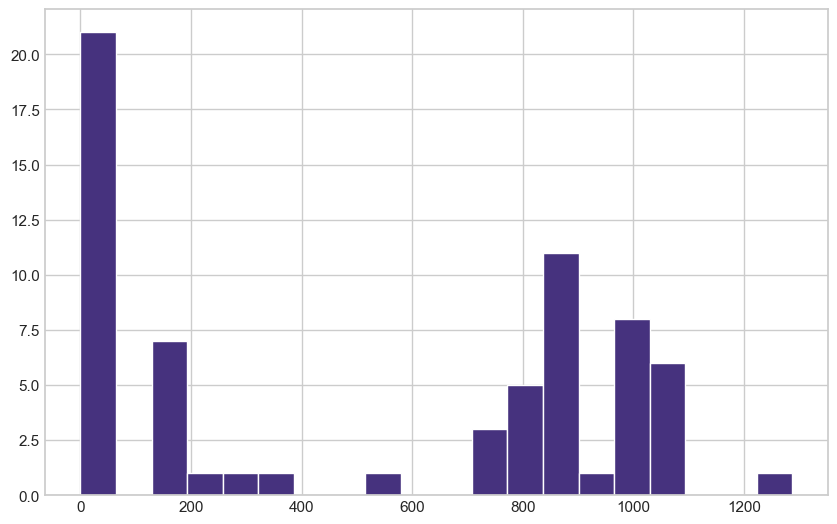

In [344]:
# owid_cov = pd.read_csv('../Data/owid-covid-data.csv').query('iso_code == @country_ISO3')
# owid_cov.to_parquet('../Data/owid-covid-data.parquet', engine='pyarrow')
owid_cov = pd.read_parquet('../Data/owid-covid-data.parquet', engine='pyarrow')

owid_cov.info()

owid_cov.nunique().hist(bins=20)


In [231]:
owid_cov = owid_cov.loc[:, owid_cov.nunique() > 1]
owid_cov['date'] = pd.to_datetime(owid_cov['date'])

owid_cov.head()

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
306301,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
306302,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
306303,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-2640.0,-4.2,-4.2,-7.858499
306304,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
306305,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [268]:
owid_cov.head()

,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
306301,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
306302,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
306303,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-2640.0,-4.2,-4.2,-7.858499
306304,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
306305,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


## CovSIRPhy Dataset Loading

The CovSIRPhy dataset is a collection of COVID-19 data from around the world, including the number of confirmed cases, recovered cases, and deaths. The data is collected from the following sources:


In [233]:
eng = cs.DataEngineer()
eng.download(country=None, databases=["covid19dh", "owid", "wpp", "japan"])

# Set Country of interest and Join Column for Other Dataframes

print("\n".join(eng.citations()))

Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
Hasell, J., Mathieu, E., Beltekian, D. et al. A cross-country database of COVID-19 testing. Sci Data 7, 345 (2020). https: //doi.org/10.1038/s41597-020-00688-8
Hirokazu Takaya (2020-2023), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan
United Nations, Department of Economic and Social Affairs, Population Division (2022). World Population Prospects 2022, Online Edition.


In [234]:
# Convert Date Column to Datetime, Resampling for only the dates in question, and Filling of Missing Values with Forward Fill and 0
eng.clean(kinds=['resample', 'fillna', 'convert_date'], date_range=('2020-01-15', '2023-07-01'))
eng.transform()

# Day to Day Differences
eng.diff(column="Confirmed", suffix="_Daily_Diff", freq="D")
eng.diff(column="Fatal", suffix="_Daily_Diff", freq="D")
eng.diff(column="Recovered", suffix="_Daily_Diff", freq="D")
eng.diff(column="Susceptible", suffix="_Daily_Diff", freq="D")
eng.diff(column="Tests", suffix="_Daily_Diff", freq="D")

# Addition
eng.add(columns=["Fatal", "Recovered"], new="Total_Removed")

# Division and Ratios
eng.div(numerator="Confirmed", denominator="Tests", new="Confirmed_per_Test")
eng.div(numerator="Fatal", denominator="Confirmed", new="Fatal_per_Confirmed")
eng.div(numerator="Recovered", denominator="Confirmed", new="Recovered_per_Confirmed")
eng.div(numerator="Fatal", denominator="Total_Removed", new="Fatal_to_Total_Removed")

eng.all().info()
eng.all().tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298288 entries, 0 to 298287
Data columns (total 39 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ISO3                                 298288 non-null  category      
 1   Province                             298288 non-null  category      
 2   City                                 298288 non-null  category      
 3   Date                                 298288 non-null  datetime64[ns]
 4   Cancel_events                        298288 non-null  Float64       
 5   Confirmed                            298288 non-null  Float64       
 6   Confirmed_Daily_Diff                 298288 non-null  Float64       
 7   Confirmed_per_Test                   298288 non-null  Float64       
 8   Contact_tracing                      298288 non-null  Float64       
 9   Country                              298288 non-null  object        
 

,ISO3,Province,City,Date,Cancel_events,Confirmed,Confirmed_Daily_Diff,Confirmed_per_Test,Contact_tracing,Country,Fatal,Fatal_Daily_Diff,Fatal_per_Confirmed,Fatal_to_Total_Removed,Gatherings_restrictions,Infected,Information_campaigns,Internal_movement_restrictions,International_movement_restrictions,Population,Product,Recovered,Recovered_Daily_Diff,Recovered_per_Confirmed,School_closing,Stay_home_restrictions,Stringency_index,Susceptible,Susceptible_Daily_Diff,Testing_policy,Tests,Tests_Daily_Diff,Total_Removed,Transport_closing,Vaccinated_full,Vaccinated_once,Vaccinations,Vaccinations_boosters,Workplace_closing
298283,ZWE,-,-,2023-06-27,1.0,264276.0,0.0,0.111045,1.0,Zimbabwe,5671.0,0.0,0.021459,0.06396,3.0,175611.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,0.0,0.314043,1.0,2.0,53.7,14174742.0,0.0,3.0,2379907.0,0.0,88665,1.0,4751270.0,6437808.0,12222754.0,1033676.0,1.0
298284,ZWE,-,-,2023-06-28,1.0,264276.0,0.0,0.111045,1.0,Zimbabwe,5671.0,0.0,0.021459,0.06396,3.0,175611.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,0.0,0.314043,1.0,2.0,53.7,14174742.0,0.0,3.0,2379907.0,0.0,88665,1.0,4751270.0,6437808.0,12222754.0,1033676.0,1.0
298285,ZWE,-,-,2023-06-29,1.0,264276.0,0.0,0.111045,1.0,Zimbabwe,5671.0,0.0,0.021459,0.06396,3.0,175611.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,0.0,0.314043,1.0,2.0,53.7,14174742.0,0.0,3.0,2379907.0,0.0,88665,1.0,4751270.0,6437808.0,12222754.0,1033676.0,1.0
298286,ZWE,-,-,2023-06-30,1.0,264276.0,0.0,0.111045,1.0,Zimbabwe,5671.0,0.0,0.021459,0.06396,3.0,175611.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,0.0,0.314043,1.0,2.0,53.7,14174742.0,0.0,3.0,2379907.0,0.0,88665,1.0,4751270.0,6437808.0,12222754.0,1033676.0,1.0
298287,ZWE,-,-,2023-07-01,1.0,264276.0,0.0,0.111045,1.0,Zimbabwe,5671.0,0.0,0.021459,0.06396,3.0,175611.0,2.0,1.0,1.0,16665409.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,0.0,0.314043,1.0,2.0,53.7,16401133.0,2226391.0,3.0,2379907.0,0.0,88665,1.0,4751270.0,6437808.0,12222754.0,1033676.0,1.0


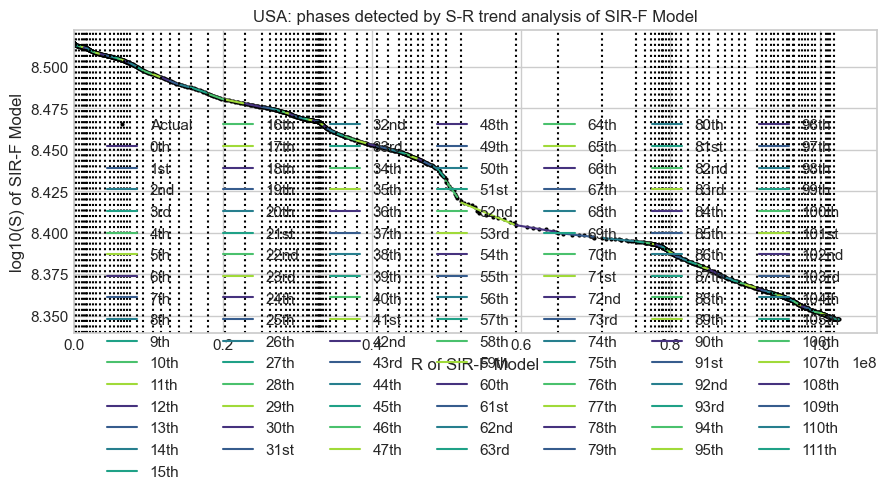

  0%|          | 0/112 [00:00<?, ?it/s]

In [235]:
# Create subset of data for the country of interest and the dates of interest
# Complement does two things here: forces always increasing cumulative values, estimates recovered cases using value of estimated recovery period

actual_df, _, _ = eng.subset(geo=country_ISO3, start_date='2020-02-07', end_date='2023-04-01', complement=True)

# Create a SIRF Model from actual df
dyn_act = cs.Dynamics.from_data(model=cs.SIRFModel, data=actual_df, name=country_ISO3)
dyn_act.register()

# # Breakdown of the SIRF Model Parameters and points of change
dyn_act.segment()

# Show summary
check = dyn_act.summary().diff()['End'].value_counts().sort_index()

# Calculate tau value and Disease Parameters from Actual SIRF Data
dyn_act.estimate()

# Interpolate Disease Parameters
track_df = dyn_act.track()



Tau value [min]: 480


,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Rt,1.000000,-0.068273,0.086122,0.683935,-0.479424,-0.067476,-0.031810,-0.208940,0.902103
theta,-0.068273,1.000000,-0.135788,-0.345369,-0.251531,0.999993,0.003780,0.847058,0.083939
kappa,0.086122,-0.135788,1.000000,0.103239,0.043509,-0.135470,-0.163952,-0.145688,0.051046
rho,0.683935,-0.345369,0.103239,1.000000,-0.110757,-0.344909,0.085476,-0.659548,0.461809
sigma,-0.479424,-0.251531,0.043509,-0.110757,1.000000,-0.251620,-0.003643,-0.256769,-0.613008
alpha1 [-],-0.067476,0.999993,-0.135470,-0.344909,-0.251620,1.000000,0.003555,0.847008,0.084553
1/alpha2 [day],-0.031810,0.003780,-0.163952,0.085476,-0.003643,0.003555,1.000000,-0.024308,-0.041686
1/beta [day],-0.208940,0.847058,-0.145688,-0.659548,-0.256769,0.847008,-0.024308,1.000000,0.027889
1/gamma [day],0.902103,0.083939,0.051046,0.461809,-0.613008,0.084553,-0.041686,0.027889,1.000000


Rt                 90
theta             112
kappa             112
rho               112
sigma             112
alpha1 [-]         29
1/alpha2 [day]    108
1/beta [day]       35
1/gamma [day]      43
dtype: int64

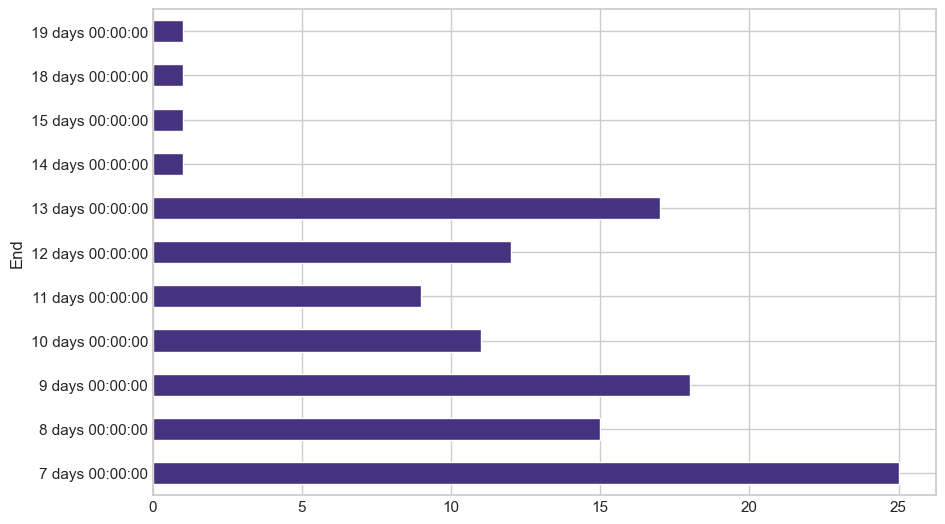

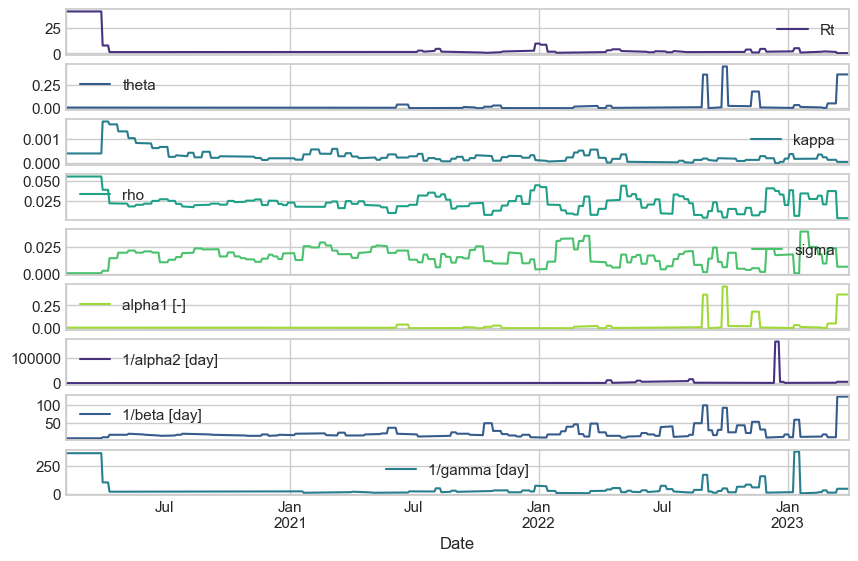

In [236]:
check.plot.barh()

print(f"Tau value [min]: {dyn_act.tau or 'un-set'}")

track_df.plot(subplots=True)

display(track_df.corr().style.background_gradient())

track_df.nunique()


In [237]:
# merge two datasets together on date
disease_df = pd.merge(actual_df, track_df, how='left', on='Date')

disease_df.info()
display(disease_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1150 entries, 2020-02-07 to 2023-04-01
Data columns (total 45 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Cancel_events                                               1150 non-null   Float64
 1   Confirmed_Daily_Diff                                        1150 non-null   Float64
 2   Confirmed_per_Test                                          1150 non-null   Float64
 3   Contact_tracing                                             1150 non-null   Float64
 4   Fatal_Daily_Diff                                            1150 non-null   Float64
 5   Fatal_per_Confirmed                                         1150 non-null   Float64
 6   Fatal_to_Total_Removed                                      1150 non-null   Float64
 7   Gatherings_restrictions                                     1150 non-

,Cancel_events,Confirmed_Daily_Diff,Confirmed_per_Test,Contact_tracing,Fatal_Daily_Diff,Fatal_per_Confirmed,Fatal_to_Total_Removed,Gatherings_restrictions,Infected,Information_campaigns,Internal_movement_restrictions,International_movement_restrictions,Population,Recovered_Daily_Diff,Recovered_per_Confirmed,School_closing,Stay_home_restrictions,Stringency_index,Susceptible,Susceptible_Daily_Diff,Testing_policy,Tests,Tests_Daily_Diff,Total_Removed,Transport_closing,Vaccinated_full,Vaccinated_once,Vaccinations,Vaccinations_boosters,Workplace_closing,Confirmed,Fatal,Recovered,Country_United States,Product_0,"Product_Johnson&Johnson, Moderna, Novavax, Pfizer/BioNTech",Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-07,0.0,0.0,inf,1.0,0.0,0.0,NaN,0.0,12,0.0,0.0,2.0,326687501.0,0.0,0.0,0.0,0.0,5.56,326687489.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,12,0,0,1,1,0,41.45,0.006751,0.000402,0.055301,0.000923,0.007,830,6,361
2020-02-08,0.0,0.0,inf,1.0,0.0,0.0,NaN,0.0,12,0.0,0.0,2.0,326687501.0,0.0,0.0,0.0,0.0,5.56,326687489.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,12,0,0,1,1,0,41.45,0.006751,0.000402,0.055301,0.000923,0.007,830,6,361
2020-02-09,0.0,0.0,inf,1.0,0.0,0.0,NaN,0.0,12,0.0,0.0,2.0,326687501.0,0.0,0.0,0.0,0.0,5.56,326687489.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,12,0,0,1,1,0,41.45,0.006751,0.000402,0.055301,0.000923,0.007,830,6,361
2020-02-10,0.0,1.0,inf,1.0,0.0,0.0,NaN,0.0,13,0.0,0.0,2.0,326687501.0,0.0,0.0,0.0,0.0,5.56,326687488.0,-1.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,13,0,0,1,1,0,41.45,0.006751,0.000402,0.055301,0.000923,0.007,830,6,361
2020-02-11,0.0,0.0,inf,1.0,0.0,0.0,NaN,0.0,13,0.0,0.0,3.0,326687501.0,0.0,0.0,0.0,0.0,8.33,326687488.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,13,0,0,1,1,0,41.45,0.006751,0.000402,0.055301,0.000923,0.007,830,6,361


## Cleaning

In [238]:
# Convert all column names to lowercase and replace spaces with underscores
disease_df.columns = [i.lower().replace(' ', '_') for i in disease_df.columns]

# Rename the index as 'date'
disease_df = disease_df.rename_axis('date')


In [239]:

# Display the count of NaN values for each column in the DataFrame where count is greater than 0
display('Amount of NaNs in ', disease_df.apply(lambda x: (x != x).sum()).loc[disease_df.apply(lambda x: (x != x).sum()) > 0])

# Display the sum of 'fatal', 'total_removed', 'fatal_to_total_removed' columns where 'fatal_to_total_removed' column has NaN
display(disease_df[disease_df.applymap(lambda x: (x != x)).fatal_to_total_removed][['fatal', 'total_removed', 'fatal_to_total_removed']].sum())

# Replace all NaN values with 0 in the DataFrame
disease_df = disease_df.applymap(lambda x: 0 if (x != x) else x)


'Amount of NaNs in '

fatal_to_total_removed    22
dtype: int32

fatal                     0.0
total_removed             0.0
fatal_to_total_removed    NaN
dtype: float64

In [240]:

# Display the count of inf values for each column in the DataFrame where count is greater than 0
display('Amount of Infs in ', disease_df.apply(lambda x: (x == np.inf).sum()).loc[disease_df.apply(lambda x: (x == np.inf).sum()) > 0])

# Display first five rows of 'confirmed', 'tests', 'confirmed_per_test' columns where 'confirmed_per_test' column has inf
display(disease_df[disease_df.applymap(lambda x: (x == np.inf)).confirmed_per_test][['confirmed', 'tests', 'confirmed_per_test']].head())

# Display the count of rows where 'confirmed' column values are greater than 'tests' column values
display(disease_df.loc[disease_df.confirmed > disease_df.tests, 'tests'].count())


'Amount of Infs in '

confirmed_per_test    23
dtype: int64

,confirmed,tests,confirmed_per_test
date,,,
2020-02-07,12,0.0,inf
2020-02-08,12,0.0,inf
2020-02-09,12,0.0,inf
2020-02-10,13,0.0,inf
2020-02-11,13,0.0,inf


23

In [241]:

# For rows where 'confirmed' column values are greater than 'tests' column values, set 'tests' column values equal to 'confirmed' column values
disease_df.loc[disease_df.confirmed > disease_df.tests, 'tests'] = disease_df.confirmed

# Display the count of rows where 'confirmed' column values are greater than 'tests' column values
display(disease_df.loc[disease_df.confirmed > disease_df.tests, 'tests'].count())


0

In [242]:
# Display first five rows of 'confirmed', 'tests', 'confirmed_per_test' columns where 'confirmed_per_test' column has inf
display(disease_df[disease_df.applymap(lambda x: (x == np.inf)).confirmed_per_test][['confirmed', 'tests', 'confirmed_per_test']].head())

# Replace the column 'confirmed_per_test' with the new ratio of 'confirmed' to 'tests'
disease_df['confirmed_per_test'] = disease_df['confirmed_per_test'].replace(np.inf, np.nan).fillna(method='backfill')

# Display first five rows of 'confirmed', 'tests', 'confirmed_per_test' columns where 'confirmed_per_test' column has inf
display(disease_df[disease_df.apply(lambda x: (x != x)).confirmed_per_test][['confirmed', 'tests', 'confirmed_per_test']].head())


,confirmed,tests,confirmed_per_test
date,,,
2020-02-07,12,12.0,inf
2020-02-08,12,12.0,inf
2020-02-09,12,12.0,inf
2020-02-10,13,13.0,inf
2020-02-11,13,13.0,inf


,confirmed,tests,confirmed_per_test
date,,,


In [243]:
display(disease_df.loc[:, disease_df.nunique() == 1].nunique())

disease_df = disease_df.loc[:, disease_df.nunique() > 1]

display(disease_df.nunique())


contact_tracing            1
population                 1
recovered_daily_diff       1
recovered_per_confirmed    1
country_united_states      1
dtype: int64

cancel_events                                                    3
confirmed_daily_diff                                          1121
confirmed_per_test                                            1118
fatal_daily_diff                                               842
fatal_per_confirmed                                           1120
fatal_to_total_removed                                           2
gatherings_restrictions                                          5
infected                                                      1140
information_campaigns                                            2
internal_movement_restrictions                                   4
international_movement_restrictions                              3
school_closing                                                   3
stay_home_restrictions                                           4
stringency_index                                                32
susceptible                                                   

## Google Datasets Loading and Cleaning

In [244]:
folder_holder = "C://Users/Samsickle/Documents/Universal_Code_Bank/BrainStation_Capstone/Data/"


def clean_df(df, location_key):
    # Filter the dataframe based on location key and date.
    df = df.query('location_key == @location_key and date >= "2020-01-03"')
    
    # Rename the columns to lowercase and replace spaces with underscores.
    df.columns = [i.lower().replace(' ', '_') for i in df.columns]

    # Convert the 'date' column to datetime format and set it as index.
    df = df.set_index('date')
    df = df.drop(columns=['location_key'])
    df.index = pd.to_datetime(df.index)

    # Print the info and head of the DataFrame.
    df.info()
    display(df.head())

    return df


In [245]:
# # Load the hospitalizations data from the CSV file
# hospitalizations_df = pd.read_csv(f'{folder_holder}hospitalizations.csv')


# # Clean the hospitalizations data using the 'clean_df' function
# hospitalizations_df = clean_df(hospitalizations_df, location_key)

# display(hospitalizations_df[hospitalizations_df.index < pd.to_datetime('2021-01-01')].isna().sum())

# hospitalizations_df[hospitalizations_df.new_intensive_care_patients.isna()].reset_index().date.hist(bins=14)
# replace_nans_column = 'new_intensive_care_patients'

# mask = (hospitalizations_df.index < pd.to_datetime('2021-01-01')) & (hospitalizations_df[replace_nans_column] != hospitalizations_df[replace_nans_column])
# hospitalizations_df.loc[mask, replace_nans_column] = 0


# replace_nans_column = 'new_ventilator_patients'

# mask = (hospitalizations_df.index < pd.to_datetime('2021-01-01')) & (hospitalizations_df[replace_nans_column] != hospitalizations_df[replace_nans_column])
# hospitalizations_df.loc[mask, replace_nans_column] = 0


# display(hospitalizations_df[hospitalizations_df.index > pd.to_datetime('2021-01-01')].isna().sum())

# hospitalizations_df[hospitalizations_df.new_intensive_care_patients.isna()].reset_index().date.hist(bins=14)
# hospitalizations_df.corr().iloc[:,1].to_frame().style.background_gradient(cmap='coolwarm')

We are employing a strategy to impute missing values in our dataset, particularly for the variables 'ICU' and 'Ventilators'. This is achieved by leveraging the correlation between 'Hospitalizations' and these two variables, and by utilizing a simple linear regression model.

For the 'ICU' variable, the linear regression model is represented as:

$$ y = c + \beta \times x $$

where:

- $y$ represents the estimated ICU values.
- $x$ represents the 'Hospitalizations'. I subtracted the values of hospitalizations on the last day to set the value of x to 0.
- $\beta$ is calculated as the standard deviation ratio between 'Hospitalizations' and 'ICU', multiplied by the correlation strength between 'Hospitalizations' and 'ICU'. 
  - That is, $\beta = \frac{\sigma_{\text{Hospitalizations}}}{\sigma_{\text{ICU}}} \times r_{\text{Hospitalizations, ICU}}$.
- $c$ represents the last observed 'ICU' value.

For the 'Ventilators' variable, the linear regression model is represented as:

$$ y = c + \beta \times x $$

where:

- $y$ represents the estimated 'Ventilators' values.
- $x$ represents the 'Hospitalizations'. I subtracted the values of hospitalizations on the last day to set the value of x to 0.
- $\beta$ is calculated as the standard deviation ratio between 'Hospitalizations' and 'Ventilators', multiplied by the correlation strength between 'Hospitalizations' and 'Ventilators'. 
  - That is, $\beta = \frac{\sigma_{\text{Hospitalizations}}}{\sigma_{\text{Ventilators}}} \times r_{\text{Hospitalizations, Ventilators}}$.
- $c$ represents the last observed 'Ventilators' value.

These models provide a basis for filling in missing values based on the linear relationship between 'Hospitalizations' and the respective variables.

In [247]:
# def estimate_missing_values_with_slr(df, target_col, predictor_col):
#     # Find Beta0 
#     last_date = df[target_col].idxmax()
#     beta0 = df.loc[last_date, target_col]

#     # Find x
#     accum_predictor = df[predictor_col]
#     last_predictor_value = df.loc[last_date, predictor_col]
#     x = accum_predictor - last_predictor_value

#     # Find Beta1
#     corr_target = df.corr().iloc[:,1][target_col]
#     beta1 = corr_target * df[target_col].std() / accum_predictor.std()

#     # Linear Regression Equation
#     predicted_target = beta0 + (beta1 * x)

#     return predicted_target



# # Single Linear Regression Equation Function and Predicted Values
# predicted_vents = estimate_missing_values_with_slr(hospitalizations_df, 'cumulative_ventilator_patients', 'cumulative_hospitalized_patients')

# predicted_icu = estimate_missing_values_with_slr(hospitalizations_df, 'cumulative_intensive_care_patients', 'cumulative_hospitalized_patients')


In [248]:
# from sklearn.linear_model import LinearRegression

# last_day = hospitalizations_df['cumulative_ventilator_patients'].idxmax()



# # Define our features and target
# features = hospitalizations_df.loc[hospitalizations_df.index < last_day, ['current_intensive_care_patients', 'new_hospitalized_patients', 'cumulative_hospitalized_patients', 'current_hospitalized_patients']]
# target = hospitalizations_df.loc[hospitalizations_df.index < last_day, ['cumulative_intensive_care_patients', 'cumulative_ventilator_patients']]

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# # Initialize the model
# model = CatBoostRegressor()

# # Fit the model on the training data
# model.fit(X_train, y_train)

# # Use the model to predict on the test data
# y_pred = model.predict(X_test)

# # Now y_pred contains the predicted values for 'cumulative_ventilator_patients' and 'cumulative_intensive_care_patients' 

# model.score(X_test, y_test)

In [249]:
# # Plotting before imputation
# ax_before = hospitalizations_df.drop(columns='cumulative_hospitalized_patients').plot(title='Before Imputation', figsize=(10,5))
# ax_before.set_xlabel("Date")
# ax_before.set_ylabel("Count")
# ax_before.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # Imputing missing values
# hospitalizations_df['cumulative_ventilator_patients'] = hospitalizations_df['cumulative_ventilator_patients'].fillna(predicted_vents) 
# hospitalizations_df['cumulative_intensive_care_patients'] = hospitalizations_df['cumulative_intensive_care_patients'].fillna(predicted_icu)

# # Plotting after imputation
# ax_after = hospitalizations_df.drop(columns='cumulative_hospitalized_patients').plot(title='After Imputed ICU/Vent Data', figsize=(13,5))
# ax_after.set_xlabel("Date")
# ax_after.set_ylabel("Count")
# ax_after.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # Adjust the layout
# plt.tight_layout()
# plt.show()


In [250]:
# # Creating a figure with two columns
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# # Plotting the "before" graphs
# hospitalizations_df[['new_ventilator_patients', 'new_intensive_care_patients']].plot(subplots=True, ax=axes[:, 0])

# # Updating data
# daily_vents = hospitalizations_df['cumulative_ventilator_patients'].diff()
# daily_icu = hospitalizations_df['cumulative_intensive_care_patients'].diff()

# hospitalizations_df['new_ventilator_patients'] = hospitalizations_df['new_ventilator_patients'].fillna(daily_vents) 
# hospitalizations_df['new_intensive_care_patients'] = hospitalizations_df['new_intensive_care_patients'].fillna(daily_icu)

# # Plotting the "after" graphs
# hospitalizations_df[['new_ventilator_patients', 'new_intensive_care_patients']].plot(subplots=True, ax=axes[:, 1])

# # Adding titles to columns
# axes[0, 0].set_title('New Ventilator Patients (before)')
# axes[1, 0].set_title('New ICU Patients (before)')
# axes[0, 1].set_title('New Ventilator Patients (after)')
# axes[1, 1].set_title('New ICU Patients (after)')

# # Adding labels to axes
# for ax in axes.flatten():
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Number of New Patients')

# plt.tight_layout()
# plt.show()


In [251]:
# hospitalizations_df.corr().iloc[:,-1].to_frame().style.background_gradient(cmap='coolwarm')


In [252]:
# # Load the mobility data from the CSV file
mobility_df = pd.read_csv(f'{folder_holder}mobility.csv')


In [253]:

# Clean the mobility data using the 'clean_df' function
mobility_df = clean_df(mobility_df, location_key)



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 941 entries, 2020-02-15 to 2022-09-12
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   mobility_retail_and_recreation  941 non-null    float64
 1   mobility_grocery_and_pharmacy   941 non-null    float64
 2   mobility_parks                  941 non-null    float64
 3   mobility_transit_stations       941 non-null    float64
 4   mobility_workplaces             941 non-null    float64
 5   mobility_residential            941 non-null    float64
dtypes: float64(6)
memory usage: 51.5 KB


,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
date,,,,,,
2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


In [254]:
mobility_df.isna().sum()

mobility_retail_and_recreation    0
mobility_grocery_and_pharmacy     0
mobility_parks                    0
mobility_transit_stations         0
mobility_workplaces               0
mobility_residential              0
dtype: int64

In [255]:
display(mobility_df.agg(['min', 'max']))

mobility_df = mobility_df.applymap(lambda x: np.abs(x)).astype('int16')

display(mobility_df.applymap(lambda x: np.abs(x)).astype('int16').agg(['min', 'max']))

,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
min,-82.0,-61.0,-38.0,-67.0,-84.0,-2.0
max,14.0,36.0,127.0,7.0,5.0,27.0


,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
min,0,0,0,0,0,0
max,82,61,127,67,84,27


In [256]:
# # Load the weather data from the CSV file
weather_df = pd.read_csv(f'{folder_holder}weather.csv')

# # Load the government response data from the CSV file
gov_response_df = pd.read_csv(f'{folder_holder}oxford-government-response.csv')


In [257]:

# Clean the weather data using the 'clean_df' function and fill any NA/NaN values with 0
weather_df = clean_df(weather_df, location_key).fillna(0)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 986 entries, 2020-01-03 to 2022-09-14
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   average_temperature_celsius  986 non-null    float64
 1   minimum_temperature_celsius  986 non-null    float64
 2   maximum_temperature_celsius  986 non-null    float64
 3   rainfall_mm                  986 non-null    float64
 4   snowfall_mm                  91 non-null     float64
 5   dew_point                    986 non-null    float64
 6   relative_humidity            986 non-null    float64
dtypes: float64(7)
memory usage: 61.6 KB


,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,dew_point,relative_humidity
date,,,,,,,
2020-01-03,1.055556,-2.648148,5.703704,0.0,30.48,-2.475309,77.390895
2020-01-04,0.006173,-6.617284,9.197531,0.0,30.48,-5.407407,67.237910
2020-01-05,5.203704,0.543210,8.580247,0.0,NaN,-2.790123,56.438457
2020-01-06,0.654321,-4.919753,8.148148,0.0,NaN,-4.993827,66.214920
2020-01-07,1.567901,-4.709877,11.012346,0.0,NaN,-5.487654,59.734417


In [258]:

# Clean the government response data using the 'clean_df' function
gov_response_df = clean_df(gov_response_df, location_key)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 917 entries, 2020-01-03 to 2022-07-07
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   school_closing                      917 non-null    float64
 1   workplace_closing                   917 non-null    float64
 2   cancel_public_events                917 non-null    float64
 3   restrictions_on_gatherings          917 non-null    float64
 4   public_transport_closing            917 non-null    float64
 5   stay_at_home_requirements           917 non-null    float64
 6   restrictions_on_internal_movement   917 non-null    float64
 7   international_travel_controls       917 non-null    float64
 8   income_support                      917 non-null    float64
 9   debt_relief                         917 non-null    float64
 10  fiscal_measures                     534 non-null    float64
 11  international_support     

,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,income_support,debt_relief,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,stringency_index
date,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [259]:
# Calculate the number of common indices between the two dataframes.
len(disease_df.index) + len(gov_response_df.index) - len(disease_df.index.symmetric_difference(gov_response_df.index))


1764

In [260]:
# Identify columns common to 'disease_df' and 'gov_response_df'.
list_of_same_columns = disease_df.columns[disease_df.columns.isin(gov_response_df.columns)]

# Count duplicate rows when the common columns of the two dataframes are concatenated.
pd.concat([disease_df[list_of_same_columns], gov_response_df[list_of_same_columns]]).duplicated().sum()


1996

In [261]:
# Remove the common columns from 'gov_response_df'.
gov_response_df = gov_response_df.drop(columns = list_of_same_columns)


### Final Merging of Datasets

<class 'pandas.core.frame.DataFrame'>
Index: 1287 entries, 306301 to 307587
Data columns (total 46 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        1287 non-null   datetime64[ns]
 1   total_cases                                 1270 non-null   float64       
 2   new_cases                                   1287 non-null   float64       
 3   new_cases_smoothed                          1282 non-null   float64       
 4   total_deaths                                1230 non-null   float64       
 5   new_deaths                                  1286 non-null   float64       
 6   new_deaths_smoothed                         1281 non-null   float64       
 7   total_cases_per_million                     1270 non-null   float64       
 8   new_cases_per_million                       1287 non-null   float64       
 9   new_ca

In [297]:
# Create a list of dataframes to be merged
time_series_dfs = [disease_df, mobility_df, gov_response_df, weather_df, owid_cov] #hospitalizations_df

# Initialize an empty dataframe to hold the column names
df_columns = pd.DataFrame()

# Iterate over each dataframe in the list and add their column names to df_columns
for i, df in enumerate(time_series_dfs):
    df_name = [x for x in globals() if globals()[x] is df][0]
    df_columns[df_name] = pd.Series(df.columns)

# Display the dataframe
df_columns


,disease_df,mobility_df,gov_response_df,weather_df,owid_cov
0,cancel_events,mobility_retail_and_recreation,cancel_public_events,average_temperature_celsius,date
1,confirmed_daily_diff,mobility_grocery_and_pharmacy,restrictions_on_gatherings,minimum_temperature_celsius,total_cases
2,confirmed_per_test,mobility_parks,public_transport_closing,maximum_temperature_celsius,new_cases
3,fatal_daily_diff,mobility_transit_stations,stay_at_home_requirements,rainfall_mm,new_cases_smoothed
4,fatal_per_confirmed,mobility_workplaces,restrictions_on_internal_movement,snowfall_mm,total_deaths
5,fatal_to_total_removed,mobility_residential,international_travel_controls,dew_point,new_deaths
6,gatherings_restrictions,NaN,income_support,relative_humidity,new_deaths_smoothed
7,infected,NaN,debt_relief,NaN,total_cases_per_million
8,information_campaigns,NaN,fiscal_measures,NaN,new_cases_per_million
9,internal_movement_restrictions,NaN,international_support,NaN,new_cases_smoothed_per_million


In [320]:
# owid_cov.corr().style.background_gradient(cmap='coolwarm')

In [343]:
drop_list = ['investment_in_vaccines', '']
checking = 'per_'

checking_series = pd.Series(df_columns.stack().sort_values(), name = 'Column Names').str.extract(f'(.*{checking}.*)').dropna()
checking_data = master_df.filter(regex=f'{checking}').isna().sum()

def last_first(x):
    min = x.dropna().idxmin()
    max = x.dropna().idxmax()
    return [min, max]

display(master_df.fatal_daily_diff.dropna())
master_df.apply(last_first)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1145    0.0
1146    0.0
1147    0.0
1148    0.0
1149    0.0
Name: fatal_daily_diff, Length: 1150, dtype: float64

,date,cancel_events,confirmed_daily_diff,confirmed_per_test,fatal_daily_diff,fatal_per_confirmed,fatal_to_total_removed,gatherings_restrictions,infected,information_campaigns,internal_movement_restrictions,international_movement_restrictions,school_closing,stay_home_restrictions,stringency_index_x,susceptible,susceptible_daily_diff,testing_policy,tests,tests_daily_diff,total_removed,transport_closing,vaccinated_full,vaccinated_once,vaccinations,...,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index_y,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,0,34,483,39,766,0,0,43,0,0,41,0,27,37,0,1140,703,0,0,0,0,849,0,0,0,...,23,23,23,30,30,493,698,310,310,310,363,1052,311,310,310,310,363,311,311,311,0,16,2,9,16
1,1149,0,703,0,1008,25,22,0,712,38,36,640,0,457,283,0,483,312,862,698,1140,276,1149,1149,1149,...,698,862,698,702,702,699,493,1149,1149,1149,937,419,429,1149,1148,1145,937,429,429,429,283,1080,366,331,1080


In [ ]:

# Use functools.reduce to merge all dataframes in the list on 'date' column, with 'left' join method
master_df = reduce(lambda a, b: pd.merge(a, b, how='left', right_on='date', left_on='date'), time_series_dfs)

# Display summary and first few rows of the master dataframe
master_df.info()
master_df.head()


confirmed_per_test                              0
fatal_per_confirmed                             0
total_cases_per_million                         0
new_cases_per_million                           0
new_cases_smoothed_per_million                  0
total_deaths_per_million                       22
new_deaths_per_million                          1
new_deaths_smoothed_per_million                 1
icu_patients_per_million                      159
hosp_patients_per_million                     159
weekly_hosp_admissions_per_million            165
total_tests_per_thousand                      310
new_tests_per_thousand                        310
new_tests_smoothed_per_thousand               317
tests_per_case                                316
total_vaccinations_per_hundred                310
people_vaccinated_per_hundred                 310
people_fully_vaccinated_per_hundred           310
total_boosters_per_hundred                    575
new_vaccinations_smoothed_per_million         311


In [276]:
# """
# Cell generated by Data Wrangler.
# """
def clean_data(master_df):
    master_df = master_df.drop(columns=['product_0', 'product_johnson&johnson,_moderna,_novavax,_pfizer/biontech', 'fiscal_measures', 'international_support', 'investment_in_vaccines', 'emergency_investment_in_healthcare'])
    return master_df

master_df = clean_data(master_df.copy())
master_df.head()

KeyError: "['product_0', 'product_johnson&johnson,_moderna,_novavax,_pfizer/biontech', 'fiscal_measures', 'international_support', 'investment_in_vaccines', 'emergency_investment_in_healthcare'] not found in axis"

In [277]:
master_df.to_parquet('../Data/master_df.parquet', compression='snappy')
master_df = pd.read_parquet('../Data/master_df.parquet')

dfSummary(master_df, is_collapsible=True)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,date[datetime64[ns]],"Min: 2020-02-07Max: 2023-04-01Duration: 1,149 days",1150 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAK4AAABRCAYAAABLyJ0iAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB4klEQVR4nO3XQWrCYBBA4flDK1olQaR6gN7ApYfoYXsIT+Cim67cCRIippYWm2661bYW/Hnwvm0yziweAVPXdSHRFLkPkC5huEK6+emFlNIgInr/2FFExGem+Zy76fO5b3/vuu5w6uHZcFNKg8lk8liW5fiSzcfj8bZt24fRaPRSFMXHNedz7qbP5749ImK329UppadT8f70xe2VZTleLBaHqqre/rp8vV6PV6vV/Xw+f57NZvU153Pups/nvr1pmv5yuRxvt9teRFwUbkREVFX1Np1OX/96QF3Xg4iI4XB49fmcu+nzuW//Njj30D9nQjJcIRmukAxXSIYrJMMVkuEKyXCFZLhCMlwhGa6QDFdIhiskwxWS4QrJcIVkuEIyXCEZrpAMV0iGKyTDFZLhCslwhWS4QjJcIRmukAxXSIYrJMMVkuEKyXCFZLhCMlwhGa6QDFdIhiskwxWS4QrJcIVkuEIyXCEZrpAMV0iGKyTDFZLhCslwhWS4QjJcIRmukAxXSIYrJMMVkuEKyXCFZLhCMlwhGa6QDFdIhiskwxWS4QrJcIVkuEIyXCEZrpAMV0iGKyTDFZLhCslwhWS4Qrr5zUtN0/Qv+fH9ft+PiGjbtr/ZbO6uOZ9zN30+9+2/6e0Ld9c5/Npkwl8AAAAASUVORK5CYII="">",0(0.0%)
2,cancel_events[float64],1. -2.02. 0.03. -1.0,629 (54.7%)349 (30.3%)172 (15.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAK4AAABICAYAAABvEc5xAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABrElEQVR4nO3cQWrbUBiF0V/FhGYiYQxejBfRxXYR2o0x1iAJmaiDjjtIKvS4T+es4Nl8YMv43WFd14I0Q1W9VtVL64Mc1Oe6ru+tD5HodLlcfo3jeG59kCNaluUxDMNv8X7daRzH8+12e5+m6aP1YY7k+Xz+nOf5fL/fX6pKuF90qqqapunjer2+tT7MAb22PkCqH60PAN8hXCIJl0jCJZJwiSRcIgmXSMIlknCJJFwiCZdIwiWScIkkXCIJl0inqr9/am59kKPxnv+f07Isj3mez+VPzbtbluVRVZ+tz5HIZcm2XJb8psH1dBJ5OCNSr18VfAR3rstdBXsF/etuV8FewTH0uqvgp73OeTgjknCJJFwiCZdIwiWScIkkXCIJl0jCJZJwiSRcIgmXSMIlknCJJFwidber0NNr4d+63FWwV9A/lyWJZFeBSB7OiLTnVwUf32xmt10FWwdsaZddBVsHbG3PXYVufm6jPQ9nRBIukYRLJOESSbhEEi6RhEsk4RJJuEQSLpGESyThEkm4RBIukYRLpF12FWwdsLXddhVsHbAllyWJZFeBSH8A9b6jUCD6FoIAAAAASUVORK5CYII="">",0(0.0%)
3,confirmed_daily_diff[float64],Mean (sd) : 90356.5 (128285.3)min < med < max:-23999.0 < 54442.5 < 1433977.0IQR (CV) : 91693.2 (0.7),"1,121 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKYAAABDCAYAAAAWAX5GAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB5klEQVR4nO3dwWoiQRSF4VNtlDY63YigOzfZZ+HSh5iHzXb2vsXsRZDYYk0cpdN5gTCmKsgc8P/W3lLkx0YouKHrOgFuiv/9AYDPPFx7QQhhKGmQef6567q3zFncsX+GGUIYTqfTn1VVTXIOPxwOryGEF+JEqmu/mIOqqiar1eqtrutTysFN05Tr9Xqy2+0GkggTSa4+yiWpruvTbDb7k3H+MGMG4M8PPBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLBEmLH1pl2Sutm37kqoQQs44K6Xv2M3CjDH2L5fL82Kx6PV6vaTNvRIrpe/dzcI8n88PZVk+LpfL03w+f02ZZaU0bvool6TRaMRKaSTjzw8sESYsESYsESYsESYsESYsESYsESYsESYsESYsESYsESYs3fwSR65v3uUsJL1nvjX3QA18KcymacrUg4/HYylJMcZyu90+psxuNpsfuXc527btxxifxuPx76IoLimzkrTf748hhF+Sku+QItnfrus+/Z4/APpad1U2NENgAAAAAElFTkSuQmCC"">",0(0.0%)
4,confirmed_per_test[float64],Mean (sd) : 0.1 (0.0)min < med < max:0.0 < 0.1 < 0.3IQR (CV) : 0.0 (2.9),"1,118 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKYAAABDCAYAAAAWAX5GAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAClklEQVR4nO3cP2/aQByH8d+VBB1Q3YWAyJY1Q6QOkbLwAjrmxfYldMjQmTVTNsQfgUJDcQydIlVVG+IjiK/N89kP29IjI9+d7TabjQFqPh36BIB/OdnnjzvnGmZWTxy+2mw2zx95PiiPvYXpnGt0Op27EEI7Zfx8Pp86574R53Ha5x2zHkJo9/v95xjjssjA2Wzm7+/v2+PxuG5mhHmE9vpXbmYWY1z2er2fCUMbH34yKA0efiCJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCGJMCFp76/vpsrz/NTMgnMuZThf8Sg5yTAXi8VplmVfLi8va7VardDHEsz4ikcVSIa5Wq1OvPfNm5ub5cXFxbTIWL7iUQ2SYb5qtVp8xeNI8fADSYQJSYQJSYQJSYQJSYQJSYQJSYQJSYQJSYQJSYQJSYQJSYQJSdK7i1Kxybj8Khcmm4yroXJhssm4GioX5is2GZcbDz+QRJiQRJiQRJiQRJiQRJiQtHW6yDnXMLN6wm+H9Xp9mjAOeDtM51yj0+nchRDaRX84yzKf5/n1crn8bmYp84k4YtvumPUQQrvf7z/HGAst7z0+PrYHg0Hz5eWltsP54Ui9a+Unxlh4FWU6nbKCgm

# ***DATA LEAKAGE ALERT***

In [280]:
master_df.columns

[Index(['date', 'cancel_events', 'confirmed_daily_diff', 'confirmed_per_test',
        'fatal_daily_diff', 'fatal_per_confirmed', 'fatal_to_total_removed',
        'gatherings_restrictions', 'infected', 'information_campaigns',
        ...
        'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
        'new_vaccinations_smoothed_per_million',
        'new_people_vaccinated_smoothed',
        'new_people_vaccinated_smoothed_per_hundred', 'stringency_index_y',
        'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative',
        'excess_mortality', 'excess_mortality_cumulative_per_million'],
       dtype='object', length=109)]

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# Initialize the imputer
imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100, random_state=42))

# Fit the imputer on the dataframe and transform
df_imputed = imputer.fit_transform(hospitalizations_df)

# Convert back to pandas dataframe and assign column names
df_imputed = pd.DataFrame(df_imputed, columns=master_df.columns)

df_imputed


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# Initialize the imputer
imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0))

# Fit the imputer on the dataframe and transform
df_imputed = imputer.fit_transform(master_df)

# Convert back to pandas dataframe and assign column names
df_imputed = pd.DataFrame(df_imputed, columns=master_df.columns)

df_imputed


In [ ]:
df_imputed.info()

### Extra Code

In [ ]:

# # Growth factor: (delta Number_n) / (delta Number_n)
# df = df.diff() / df.diff().shift(freq="D")

# # Rolling mean (window: 7 days)
# df = df.rolling(7).mean().dropna().loc[:covid_df["Date"].max(), :]
# numeric_columns_assessment(eng.all()).T

In [ ]:
# """
# Cell generated by Data Wrangler.
# """
# def clean_data(df):
#     # Filter rows based on column: 'location_key'
#     # df = df[df['location_key'].str.contains(r"^(US|CA|DE|GB|FR|JP|AU|BR|ZA|IN)$", na=False)]
#     df = df[df['location_key'].str.contains(r"^(US)$", na=False)] # only the us to start

#     # Change column type to datetime64[ns] for column: 'date'
#     try:
#         df = df.astype({'date': 'datetime64[ns]'})
#     except:
#         pass
#     # Change column type to category for column: 'location_key'
#     df = df.astype({'location_key': 'category'})
#     return df


# time_series_dfs = list(map(clean_data, timeland_df))

# # # Assume dfs is your list of dataframes
# time_series_dfs = reduce(lambda left,right: pd.merge(left,right,on=['location_key', 'date'], how='left'), time_series_dfs).copy()


In [ ]:
# time_series_dfs.to_parquet(f'{folder_holder}time_series_dfs.parquet.gzip', compression='gzip')

# time_series_dfs = pd.read_parquet(f'{folder_holder}time_series_dfs.parquet.gzip')

In [ ]:
# time_series_dfs_line_plot = time_series_dfs.dropna(subset='new_confirmed').copy()
# # sns.lineplot(data = time_series_dfs_line_plot, x = 'date', y = 'new_confirmed')

# time_series_dfs_line_plot.plot(x = 'date', y = 'new_confirmed', figsize = (15, 10))

# # add lines for each column
# fig = px.line(time_series_dfs_line_plot, x=air_traffic.index, y=air_traffic.columns,)

# # axis labels and title
# fig.update_layout(
#     yaxis_title="Passenger-miles (billions)", 
#     legend_title="", 
#     title="Daily air travel from 1979 to 2002"
# )

# # activate slider
# fig.update_xaxes(rangeslider_visible=True)

# fig.show()

In [ ]:
# folder_holder = "C://Users/Samsickle/Documents/BrainStation_Capstone/Data/"
# # C:\Users\Samsickle\Documents\BrainStation_Capstone\Data

# # # # time series data
# # hospitalizations_df = pd.read_csv(f'{folder_holder}hospitalizations.csv') # 2
# # mobility_df = pd.read_csv(f'{folder_holder}mobility.csv') # 4
# # gov_response_df = pd.read_csv(f'{folder_holder}oxford-government-response.csv') # 5
# # weather_df = pd.read_csv(f'{folder_holder}weather.csv') # 6

# epid_df = pd.read_csv(f'{folder_holder}epidemiology.csv') # 1
# # vac_df = pd.read_csv(f'{folder_holder}vaccinations.csv') # 3


In [ ]:
# epid_df.sample(5)

In [ ]:
# Performs a Fillna with FFill on the data set or a fillna with a 0 if there is no previous value
# Retrieves only the dates between '2020-01-01' and '2022-09-15'

# eng.clean(kinds=['resample', 'fillna'], date_range=('2020-01-03', '2022-09-15'))
# eng.all().query('ISO3 == @country_ISO3').isna().sum().sum()

# creates an engine with only USA data and with the desire date
# complement does three things, forces always increasing cumulate values, estimates recovered cases using value of estimated recovery period

# eng.subset(geo=country_ISO3, start_date='2020-01-03', end_date='2022-09-15', complement=True)
# eng.all().ISO3.unique(), eng.all().Date.min(), eng.all().Date.max()
# Uses the SIR model to estimate the number of infected and susceptible people

# main_variables = ['Infected', 'Susceptible']
# eng.transform()
# eng.all().query('ISO3 == @country_ISO3').info()
# eng.all().query('ISO3 == @country_ISO3')[main_variables].describe().T
# estimates the length of recovery and the length of the incubation period


# eng.clean()
# eng.transform()


# actual_df, status, _ = eng.subset(geo=country_ISO3, start_date='2020-01-03', end_date='2022-09-15', complement=True)
# print(status)
# actual_df.tail()



# with_df, status, status_dict = eng.subset(geo=@country_ISO3, start_date='2020-01-01', end_date='2022-09-15', complement=True)
# print(f"{status}\n")
# print(status_dict)
# with_df.info()
# with_df.head()


# """
# Cell generated by Data Wrangler.
# """
# def clean_data(with_df):
#     # Replace all instances of 0 with 0 in column: 'Positive_rate'
#     with_df.loc[with_df['Positive_rate'] != with_df['Positive_rate'], 'Positive_rate'] = 0
#     with_df.loc[with_df['Positive_rate'] == np.inf, 'Positive_rate'] = 0
#     return with_df

# with_df_clean = clean_data(with_df.copy())
# with_df_clean.head()
# cs.line_plot(with_df[["Confirmed", "Fatal", "Recovered"]], title="USA: records WITH complement")
# with_df.info()

# snr_act = cs.ODEScenario.auto_build(geo=country_ISO3, model=cs.SIRFModel, complement=True)

# snr_act.simulate(name="Baseline");
# dyn_act = snr_act.to_dynamics(name="Baseline")
# # Show summary
# display(dyn_act.summary())
# # Simulation
# dyn_act_df = dyn_act.simulate(model_specific=False)
# cs.line_plot(
#     dyn_act_df.drop("Susceptible", axis=1), "USA: Simulated data (Baseline scenario)")

Data Wireframe:

1. Date and Location:
    - 'date' - the day of the observations
    - 'location_key' - the country of the observations. I choose ten countries of interest in different regions

United States (US)  
Canada (CA)  
Germany (DE)  
United Kingdom (GB)  
France (FR)  
Japan (JP)  
Australia (AU)  
Brazil (BR)  
South Africa (ZA)  
India (IN)  
These countries are often used as indicators for their respective regions due to their significant economic influence, political stability, and comprehensive data collection practices.

2. COVID-19 Statistics:
    - 'new_confirmed' (New Positive Cases) - the number of new confirmed cases of COVID-19, this includes some negative numbers to account for data corrections in the previous days, however because these numbers are aggregated accross a whole country, the negative numbers are often very small and remain positive
    - 'new_deceased' (New Deaths) - the number of new deaths due to COVID-19 also shares the negative number problem
    - 'new_hospitalized_patients' (New Hospitalizations) 

3. Mobility Data:
    - 'mobility_retail_and_recreation'
    - 'mobility_grocery_and_pharmacy'
    - 'mobility_parks'
    - 'mobility_transit_stations'
    - 'mobility_workplaces'
    - 'mobility_residential'



4. Vaccination Data:
    - 'new_persons_vaccinated'
    - 'cumulative_persons_vaccinated'
    - 'new_persons_fully_vaccinated'
    - 'cumulative_persons_fully_vaccinated'
    - 'new_vaccine_doses_administered'
    - 'cumulative_vaccine_doses_administered'

5. Policy Measures:
    - 'school_closing'
    - 'workplace_closing'
    - 'cancel_public_events'
    - 'restrictions_on_gatherings'
    - 'public_transport_closing'
    - 'stay_at_home_requirements'
    - 'restrictions_on_internal_movement'
    - 'international_travel_controls'
    - 'income_support'
    - 'debt_relief'
    - 'fiscal_measures'
    - 'international_support'
    - 'public_information_campaigns'
    - 'testing_policy'
    - 'contact_tracing'
    - 'emergency_investment_in_healthcare'
    - 'investment_in_vaccines'
    - 'facial_coverings'
    - 'vaccination_policy'
    - 'stringency_index'

6. Weather Data:
    - 'average_temperature_celsius'
    - 'minimum_temperature_celsius'
    - 'maximum_temperature_celsius'
    - 'rainfall_mm'
    - 'snowfall_mm'
    - 'dew_point'
    - 'relative_humidity'


In [ ]:
# # location dfs
# geography_df = pd.read_csv(f'{folder_holder}geography.csv') #1
# health_df = pd.read_csv(f'{folder_holder}health.csv') #2
# demographics_df = pd.read_csv(f'{folder_holder}demographics.csv') #3
# economics_df = pd.read_csv(f'{folder_holder}economy.csv') #4


# locationland_df = [geography_df, health_df, demographics_df, economics_df]

In [ ]:
# location_df = list(map(clean_data, locationland_df))

# # Assume dfs is your list of dataframes
# location_df = reduce(lambda left,right: pd.merge(left,right,on='location_key', how='left'), location_df).copy()

# location_df.head()


In [ ]:

# location_df.to_pickle('../Data/location_df.pkl')
# location_df = pd.read_pickle('../Data/location_df.pkl')

# location_df.sample(3)

This dataframe provides a comprehensive snapshot of COVID-19 data, mobility metrics, government restrictions, and weather conditions for specific locations on specific dates. Here's a brief overview of the columns:

1. `Entry ID`: A unique identifier for each row in the dataframe.
2. `Date`: The date for the day on which the data was recorded.
3. `Location Key`: A code representing the location (10 different countries in total) for which the data is reported.

4. `New Confirmed`: The number of new confirmed COVID-19 cases on the given date.
5. `New Deceased`: The number of new COVID-19 related deaths on the given date.
6. `New Recovered`: The number of new recoveries from COVID-19 on the given date.
7. `New Tested`: The number of new COVID-19 tests conducted on the given date.

8. `New Hospitalizations`: The number of new hospitalizations due to COVID-19 on the given date.
9. `Current Hospitalizations`: The total number of current hospitalizations due to COVID-19 on the given date.

10. `New Fully Vaccinated (29+ other Vaccination Columns)`: The number of new fully vaccinated individuals on the given date. There are 29 other columns related to vaccination data here too.

11. `Retail and Recreation Mobility (5+ other Mobility Metrics)`: A measure of mobility in retail and recreation spaces, along with 5 other columns related to different aspects of mobility.

12. `School Closing (19+ other Government Restrictions)`: A measure indicating whether schools were closed on the given date, along with 19 other columns related to different government restrictions.

13. `Average Temp (6+ Other Weather Columns)`: The average temperature on the given date, along with 6 other columns related to different weather conditions.

In total there are 9880 and 82 rows for 6.3mbs of data. The main way I could increase or decrease the size of the dataset would be to include more countries, regions, or counties in the analysis. For now this is my starter df.
